In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/train_data_patch/class_3+/her2-3+-score_train_3973.png
/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/train_data_patch/class_3+/her2-3+-score_train_4909.png
/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/train_data_patch/class_3+/her2-3+-score_train_1813.png
/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/train_data_patch/class_3+/her2-3+-score_train_488.png
/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/train_data_patch/class_3+/her2-3+-score_train_3883.png
/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/train_data_patch/class_3+/her2-1+-score_train_10.png
/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/train_data_patch/class_3+/her2-3+-score_train_4575.png
/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/train_data_patch/class_3+/her2-3+-score_train_3643.png
/ka

In [75]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

# Global configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4
CLASS_NAMES = ['class_0', 'class_1+', 'class_2+', 'class_3+']

In [76]:
# Load training dataset
train_dataset = image_dataset_from_directory(
    "/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/train_data_patch",
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    "/kaggle/input/her2-breast-cancer-detection-v1-0-0/Patch-based-dataset/test_data_patch",
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Apply preprocessing
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)

Found 8797 files belonging to 4 classes.
Found 2200 files belonging to 4 classes.


In [77]:
# Load EfficientNetV2B0 base model
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [78]:
# # Compile model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Train model
# model.fit(train_dataset, epochs=5)

# Compile model (first phase)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train and save training history
history1 = model.fit(train_dataset, epochs=5)


Epoch 1/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 55s 101ms/step - accuracy: 0.6805 - loss: 0.7514
Epoch 2/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.8522 - loss: 0.3810
Epoch 3/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.8683 - loss: 0.3359
Epoch 4/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.8723 - loss: 0.3151
Epoch 5/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.8762 - loss: 0.2939


In [79]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,934,686 (22.64 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 10,250 (40.04 KB)

In [80]:
# # Unfreeze last 20 layers of the base model
# base_model.trainable = True
# for layer in base_model.layers[:-20]:
#     layer.trainable = False

# # Recompile with a lower learning rate
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Fine-tune model
# model.fit(train_dataset, epochs=5)

# Unfreeze top layers
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Re-compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune and save second history
history2 = model.fit(train_dataset, epochs=100)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 58s 103ms/step - accuracy: 0.8316 - loss: 0.4232
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.8593 - loss: 0.3632
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.8724 - loss: 0.3227
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.8827 - loss: 0.3230
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.8792 - loss: 0.3183
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.8862 - loss: 0.3033
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.8864 - loss: 0.2911
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.8860 - loss: 0.2892
Epoch 9/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.8855 - loss: 0.2976
Epoch 10/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.8915 - loss: 0.2877
Epoch 11/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.8918 - loss: 0.2817
Epoch 12/100
275/2

In [81]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,431,326 (24.53 MB)

 Trainable params: 253,444 (990.02 KB)

 Non-trainable params: 5,670,992 (21.63 MB)

 Optimizer params: 506,890 (1.93 MB)

In [82]:
def plot_training_curve(history, title_prefix=''):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs_range = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_range, acc, marker='o')
    plt.title(f'{title_prefix}Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss plot
    plt.figure(figsize=(6, 4))
    plt.plot(epochs_range, loss, marker='o', color='red')
    plt.title(f'{title_prefix}Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

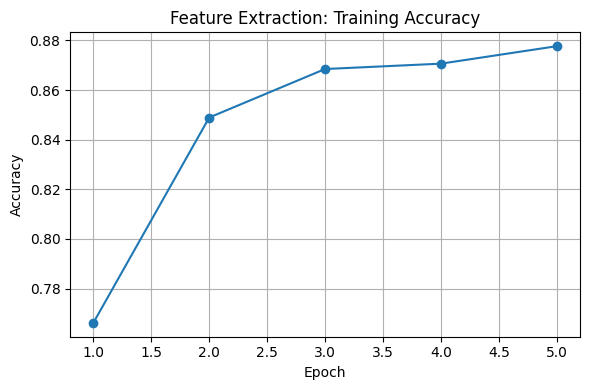

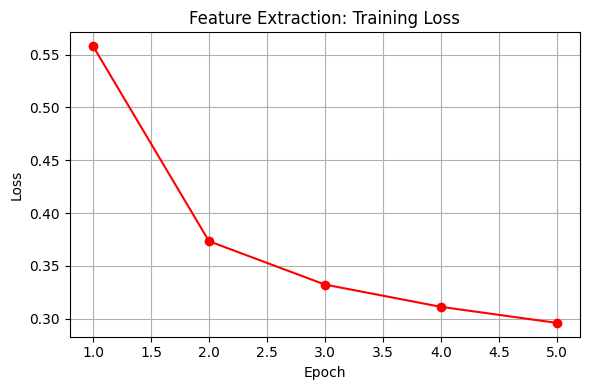

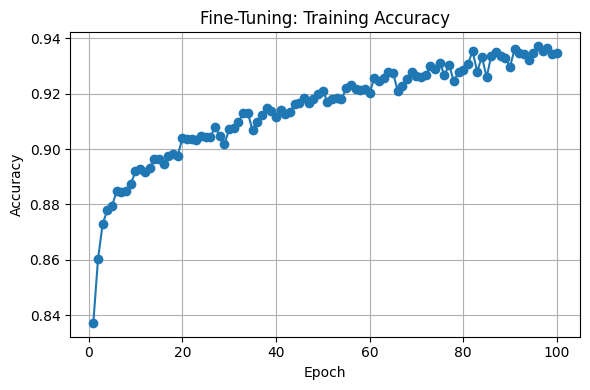

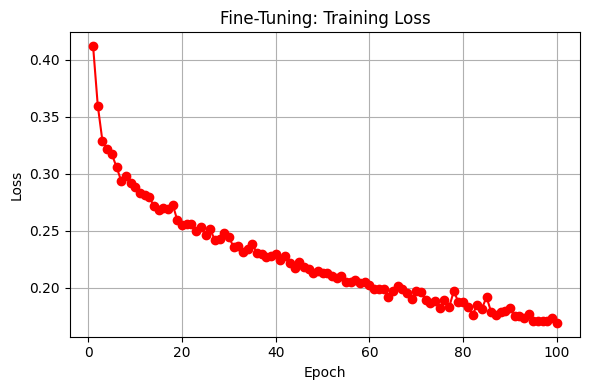

In [83]:
# After training phase 1
plot_training_curve(history1, title_prefix='Feature Extraction: ')

# After fine-tuning phase 2
plot_training_curve(history2, title_prefix='Fine-Tuning: ')

In [84]:
# Evaluate on test dataset
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict labels
y_true, y_pred, y_probs = [], [], []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_probs.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.9241 - loss: 0.1966
Test Loss: 0.1821
Test Accuracy: 0.9291
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

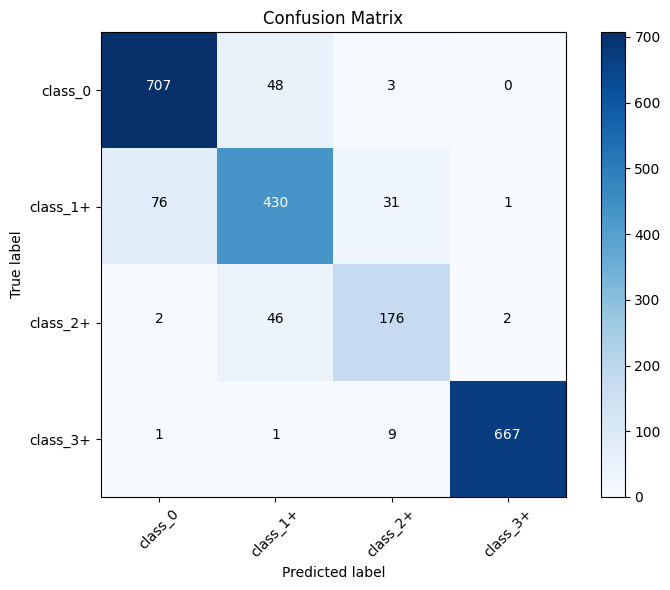

In [85]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))  # Adjusted size
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(len(class_names)), range(len(class_names))):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot and show
plot_confusion_matrix(cm, CLASS_NAMES)
plt.show()

In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Convert predictions and true labels to numpy arrays (if not already)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score (per class)
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Print metrics
print("🔹 Statistical Evaluation Metrics")
print("---------------------------------")
print(f"Accuracy: {accuracy:.4f}\n")

for i, class_name in enumerate(CLASS_NAMES):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-Score:  {f1[i]:.4f}")
    print()

# Optional: Detailed classification report
print("📋 Full Classification Report")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

🔹 Statistical Evaluation Metrics
---------------------------------
Accuracy: 0.9291

Class: class_0
  Precision: 0.9274
  Recall:    0.9433
  F1-Score:  0.9353

Class: class_1+
  Precision: 0.8696
  Recall:    0.8550
  F1-Score:  0.8622

Class: class_2+
  Precision: 0.8784
  Recall:    0.8628
  F1-Score:  0.8705

Class: class_3+
  Precision: 0.9941
  Recall:    0.9941
  F1-Score:  0.9941

📋 Full Classification Report
              precision    recall  f1-score   support

     class_0       0.93      0.94      0.94       758
    class_1+       0.87      0.86      0.86       538
    class_2+       0.88      0.86      0.87       226
    class_3+       0.99      0.99      0.99       678

    accuracy                           0.93      2200
   macro avg       0.92      0.91      0.92      2200
weighted avg       0.93      0.93      0.93      2200



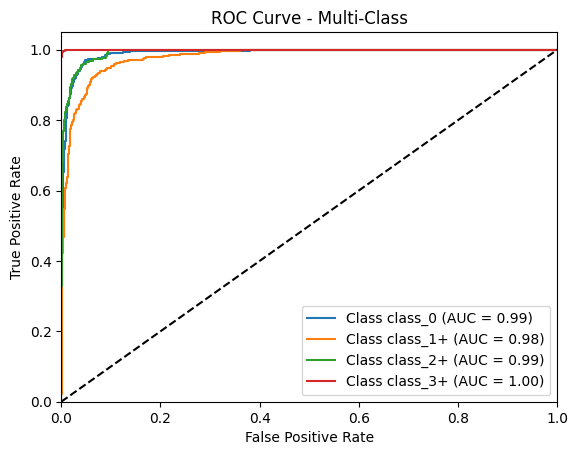

In [87]:
# Binarize true labels
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

# Compute ROC and AUC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure()
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f"Class {CLASS_NAMES[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.show()

In [88]:
# Save model in HDF5 format
model.save("her2_classifier_5 epochs model.h5")
# Or use SavedModel format:
# model.save("her2_classifier_model")